# Plot site pair scatter plots (Fig. 2)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import scipy.stats as stats
from scipy.interpolate import interp1d
import pickle
import altair as alt
import math
import xarray as xr
from altair import datum
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
df_stations = pickle.load(open('../../data/snv_dataframes/snv_temp_precip_cluster_gdf_snvs_quantiles.pkl','rb'))

/var/folders/s4/pymynk_14w75x2ghv0xjkqlm0000gn/T/ipykernel_4860/1518408164.py:1: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df_stations = pickle.load(open('../../data/snv_dataframes/snv_temp_precip_cluster_gdf_snvs_quantiles.pkl','rb'))


In [3]:
ucrb = pickle.load(open('../../data/misc/ucrb.pkl', 'rb'))

<Axes: >

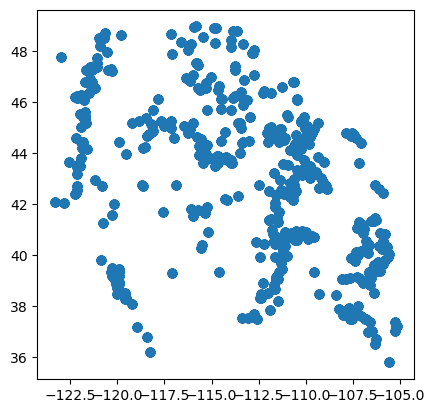

In [63]:
df_stations.plot()

In [66]:
ucrb_stations = df_stations.clip(ucrb)

<Axes: >

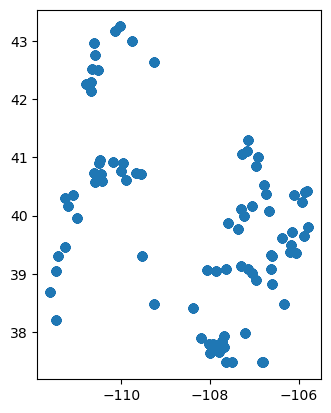

In [67]:
ucrb_stations.plot()

In [73]:
len(ucrb_stations.index.get_level_values(0).unique())

85

In [68]:
len(ucrb_stations)

2720

In [4]:
snowmodel = xr.open_dataset('../../data/snowmodel/sm_swed_ucrb_match_2000_2021.nc', decode_coords="all")

### Predict SWE at Butte using Schofield Pass: 

In [5]:
site1 = '380_CO_SNTL' # Butte station
site2 = '737_CO_SNTL' # Schofield Pass station

In [6]:
df_butte_pred = pd.DataFrame(df_stations.loc[pd.IndexSlice[site1],'station_swe'])
df_butte_pred = df_butte_pred.rename(columns={'station_swe':'butte_swe'})
df_butte_pred['schofield_swe'] = df_stations.loc[pd.IndexSlice[site2], 'station_swe']

In [7]:
df_butte_pred['SNV'] = np.nan
for year in np.arange(1990,2022):
    df_butte_pred.loc[(df_butte_pred.index==year), 'SNV'] = (df_stations.loc[(df_stations.index.get_level_values(1) == year) & (df_stations.index.get_level_values(0) == site2),'station_n'].values[0] * df_stations.loc[(df_stations.index.get_level_values(1) != year) & (df_stations.index.get_level_values(0) == site1),'station_swe'].std()) + df_stations.loc[(df_stations.index.get_level_values(1) != year) & (df_stations.index.get_level_values(0) == site1),'station_swe'].mean()

#### Quantile method:

In [8]:
df_butte_pred['Quantile'] = np.nan

quantiles = np.linspace(0,1,100)

for year in np.arange(1990, 2022):
    q = df_stations.loc[(df_stations.index.get_level_values(0)==site2) & (df_stations.index.get_level_values(1)==year)]['quantile_q8']
    cdf = np.quantile(df_stations.loc[(df_stations.index.get_level_values(1) != year) & (df_stations.index.get_level_values(0) == site1)]['station_swe'], quantiles, method='median_unbiased')
    df_butte_pred.loc[(df_butte_pred.index == year),'Quantile'] = np.interp(q, quantiles, np.sort(cdf))

In [9]:
x = df_stations[(df_stations.index.get_level_values(0) == site1) & (df_stations.index.get_level_values(1) == 1990)].geometry.x.values[0]
y = df_stations[(df_stations.index.get_level_values(0) == site1) & (df_stations.index.get_level_values(1) == 1990)].geometry.y.values[0]

In [10]:
sampled_sm = snowmodel.swed.sel(x=x, y=y, method = 'nearest').values.tolist()
nans = [np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
sampled_sm = nans + sampled_sm
df_butte_pred['SnowModel'] = sampled_sm

### Calculate metrics:

In [11]:
df_butte_pred['difference_snv'] = df_butte_pred['SNV'] - df_butte_pred['butte_swe']
df_butte_pred['difference_quantile'] = df_butte_pred['Quantile'] - df_butte_pred['butte_swe']
df_butte_pred['difference_sm'] = df_butte_pred['SnowModel'] - df_butte_pred['butte_swe']

In [12]:
station_list = ['Butte','Butte','Butte','Dry Lake', 'Dry Lake','Dry Lake',]
methods = ['SNV','Quantile', 'SnowModel','SNV','Quantile', 'SnowModel',]

tuples = list(zip(station_list, methods))

metrics_index = pd.MultiIndex.from_tuples(tuples, names=["station", "method"])

In [13]:
metrics_df = pd.DataFrame(columns=[['R','MD','RMSE']], index=metrics_index)
metrics_df

R   MD RMSE
station  method                  
Butte    SNV        NaN  NaN  NaN
         Quantile   NaN  NaN  NaN
         SnowModel  NaN  NaN  NaN
Dry Lake SNV        NaN  NaN  NaN
         Quantile   NaN  NaN  NaN
         SnowModel  NaN  NaN  NaN

In [14]:
# SNV
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Butte') & (metrics_df.index.get_level_values(1)=='SNV'), 'MD'] = df_butte_pred['difference_snv'].mean()
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Butte') & (metrics_df.index.get_level_values(1)=='SNV'), 'RMSE'] = np.sqrt((df_butte_pred['difference_snv']**2).mean())
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Butte') & (metrics_df.index.get_level_values(1)=='SNV'), 'R'] = np.corrcoef(df_butte_pred['butte_swe'], df_butte_pred['SNV'])[0,1]

# Quantile Mapping
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Butte') & (metrics_df.index.get_level_values(1)=='Quantile'), 'MD'] = df_butte_pred['difference_quantile'].mean()
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Butte') & (metrics_df.index.get_level_values(1)=='Quantile'), 'RMSE'] = np.sqrt((df_butte_pred['difference_quantile']**2).mean())
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Butte') & (metrics_df.index.get_level_values(1)=='Quantile'), 'R'] = np.corrcoef(df_butte_pred['butte_swe'], df_butte_pred['Quantile'])[0,1]

# SnowModel
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Butte') & (metrics_df.index.get_level_values(1)=='SnowModel'), 'MD'] = df_butte_pred[df_butte_pred.index>=2000]['difference_sm'].mean()
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Butte') & (metrics_df.index.get_level_values(1)=='SnowModel'), 'RMSE'] = np.sqrt((df_butte_pred[df_butte_pred.index>=2000]['difference_sm']**2).mean())
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Butte') & (metrics_df.index.get_level_values(1)=='SnowModel'), 'R'] = np.corrcoef(df_butte_pred[df_butte_pred.index>=2000]['butte_swe'], df_butte_pred[df_butte_pred.index>=2000]['SnowModel'])[0,1]

### Plot prediction scatter:

In [38]:
data2 = {'x': np.linspace(0,1,100),
        'y': np.linspace(0,1,100)}
df_lin = pd.DataFrame(data2)
    
line = alt.Chart(df_lin).mark_line().encode(
    alt.X('x:Q'),
    alt.Y('y:Q'),
    color=alt.value("#808080")
)

butte_predict = alt.Chart(pd.melt(df_butte_pred, id_vars=['butte_swe'], value_vars=['SNV',
       'Quantile', 'SnowModel'])).mark_circle().encode(
        x = alt.X('butte_swe').title('Measured SWE (m) at Butte SNOTEL '), 
        y = alt.Y('value').title('Predicted SWE (m) at Butte SNOTEL'),
        color=alt.Color('variable', sort=['SNV','Quantile'])
    )#.properties(title='Predicted SWE at Butte')

combined = (butte_predict + line) 
combined

alt.LayerChart(...)

### Predict SWE at Dry Lake using Columbine: 

In [39]:
site1 = '457_CO_SNTL' #Dry Lake
site2 = '408_CO_SNTL' #Columbine

In [40]:
df_drylake_pred = pd.DataFrame(df_stations.loc[pd.IndexSlice[site1],'station_swe'])
df_drylake_pred = df_drylake_pred.rename(columns={'station_swe':'drylake_swe'})
df_drylake_pred['columbine_swe'] = df_stations.loc[pd.IndexSlice[site2], 'station_swe']

#### SNV method on untransformed data from Schofield Pass:

In [41]:
df_drylake_pred['SNV'] = np.nan
for year in np.arange(1990,2022):
    df_drylake_pred.loc[(df_drylake_pred.index==year), 'SNV'] = (df_stations.loc[(df_stations.index.get_level_values(1) == year) & (df_stations.index.get_level_values(0) == site2),'station_n'].values[0] * df_stations.loc[(df_stations.index.get_level_values(1) != year) & (df_stations.index.get_level_values(0) == site1),'station_swe'].std()) + df_stations.loc[(df_stations.index.get_level_values(1) != year) & (df_stations.index.get_level_values(0) == site1),'station_swe'].mean()

#### Quantile method:

In [42]:
df_drylake_pred['Quantile'] = np.nan

quantiles = np.linspace(0,1,100)

for year in np.arange(1990, 2022):
    q = df_stations.loc[(df_stations.index.get_level_values(0)==site2) & (df_stations.index.get_level_values(1)==year)]['quantile_q8']
    cdf = np.quantile(df_stations.loc[(df_stations.index.get_level_values(1) != year) & (df_stations.index.get_level_values(0) == site1)]['station_swe'], quantiles, method='median_unbiased')
    df_drylake_pred.loc[(df_drylake_pred.index == year),'Quantile'] = np.interp(q, quantiles, np.sort(cdf))

In [43]:
x = df_stations[(df_stations.index.get_level_values(0) == site1) & (df_stations.index.get_level_values(1) == 1990)].geometry.x.values[0]
y = df_stations[(df_stations.index.get_level_values(0) == site1) & (df_stations.index.get_level_values(1) == 1990)].geometry.y.values[0]

In [44]:
sampled_sm = snowmodel.swed.sel(x=x, y=y, method = 'nearest').values.tolist()
nans = [np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
sampled_sm = nans + sampled_sm
df_drylake_pred['SnowModel'] = sampled_sm

### Plot scatter:

In [45]:
data = {'x': np.linspace(0,1,100),
        'y': np.linspace(0,1,100)}
df_lin = pd.DataFrame(data)
    
line = alt.Chart(df_lin).mark_line().encode(
    alt.X('x:Q'),
    alt.Y('y:Q'),
    color=alt.value("#808080")
)

dl_predict = alt.Chart(pd.melt(df_drylake_pred, id_vars=['drylake_swe'], value_vars=['SNV',
       'Quantile', 'SnowModel'])).mark_circle().encode(
        x = alt.X('drylake_swe').title('Measured SWE (m) at Dry Lake SNOTEL'), 
        y = alt.Y('value').title('Predicted SWE (m) at Dry Lake'),
        color=alt.Color('variable', sort=['SNV','Quantile'])
    )#.properties(title='Predicted SWE at Dry Lake')

combined = (dl_predict + line) 
combined

alt.LayerChart(...)

In [46]:
combined

alt.LayerChart(...)

In [22]:
combined = alt.hconcat(butte_predict + line, dl_predict + line).configure_legend(title=None,orient='top-left', fillColor='white',strokeColor='dark-grey', padding=4)
combined

alt.HConcatChart(...)

In [24]:
combined = alt.hconcat(butte_predict + line, dl_predict + line)
combined
combined.save('../../figures/station_pairs_332025.png', ppi=500)

In [59]:
df_drylake_pred['difference_snv'] = df_drylake_pred['SNV'] - df_drylake_pred['drylake_swe']
df_drylake_pred['difference_quantile'] = df_drylake_pred['Quantile'] - df_drylake_pred['drylake_swe']
df_drylake_pred['difference_sm'] = df_drylake_pred['SnowModel'] - df_drylake_pred['drylake_swe']

In [60]:
df_drylake_pred['difference_snv'] = df_drylake_pred['SNV'] - df_drylake_pred['drylake_swe']
df_drylake_pred['difference_quantile'] = df_drylake_pred['Quantile'] - df_drylake_pred['drylake_swe']
df_drylake_pred['difference_sm'] = df_drylake_pred['SnowModel'] - df_drylake_pred['drylake_swe']

In [61]:
# SNV
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Dry Lake') & (metrics_df.index.get_level_values(1)=='SNV'), 'MD'] = df_drylake_pred['difference_snv'].mean()
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Dry Lake') & (metrics_df.index.get_level_values(1)=='SNV'), 'RMSE'] = np.sqrt((df_drylake_pred['difference_snv']**2).mean())
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Dry Lake') & (metrics_df.index.get_level_values(1)=='SNV'), 'R'] = np.corrcoef(df_drylake_pred['drylake_swe'], df_drylake_pred['SNV'])[0,1]

# Quantile Mapping
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Dry Lake') & (metrics_df.index.get_level_values(1)=='Quantile'), 'MD'] = df_drylake_pred['difference_quantile'].mean()
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Dry Lake') & (metrics_df.index.get_level_values(1)=='Quantile'), 'RMSE'] = np.sqrt((df_drylake_pred['difference_quantile']**2).mean())
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Dry Lake') & (metrics_df.index.get_level_values(1)=='Quantile'), 'R'] = np.corrcoef(df_drylake_pred['drylake_swe'], df_drylake_pred['Quantile'])[0,1]

# Cumulative Precipitation
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Dry Lake') & (metrics_df.index.get_level_values(1)=='SnowModel'), 'MD'] = df_drylake_pred[df_drylake_pred.index>=2000]['difference_sm'].mean()
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Dry Lake') & (metrics_df.index.get_level_values(1)=='SnowModel'), 'RMSE'] = np.sqrt((df_drylake_pred[df_drylake_pred.index>=2000]['difference_sm']**2).mean())
metrics_df.loc[(metrics_df.index.get_level_values(0)=='Dry Lake') & (metrics_df.index.get_level_values(1)=='SnowModel'), 'R'] = np.corrcoef(df_drylake_pred[df_drylake_pred.index>=2000]['drylake_swe'], df_drylake_pred[df_drylake_pred.index>=2000]['SnowModel'])[0,1]

In [62]:
metrics_df

R        MD      RMSE
station  method                                 
Butte    SNV        0.905556 -0.000864  0.049109
         Quantile   0.891403  -0.00141  0.052364
         SnowModel  0.868342 -0.193225  0.200471
Dry Lake SNV        0.925661 -0.000358  0.050786
         Quantile   0.921994   0.00364  0.051827
         SnowModel  0.920841 -0.272367  0.278421